# Train a Simplified LeNet5 Model to classify CIFAR-10 data

LeNet5 is a well know model which was introduced in paper "Gradient-based learning applied to document recognition" by LeCun in 1998. In the paper it is used to classify the MNIST handscripts numbers. Here we will train a simplified LeNet5 model to classify CIFAR-10 data.

## CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:

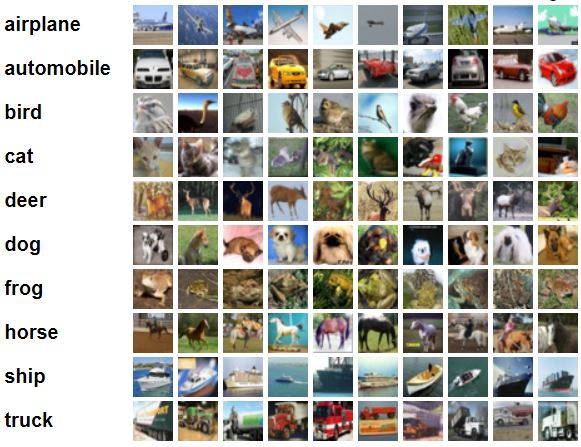

For more information, please refer to below link.

http://www.cs.toronto.edu/~kriz/cifar.html

## Section 1 Define Super Training Parameters

- epoch: define the iteration of the train
- batch_size: define the train batch size. It depends on how large the memory is. CIFAR-10 is a very small images. 200 - 500 should be good. 
- test_size: define the test batch size.  
- learn rate (lr): The start learn rate for Agagrad
- keep_prob: the probability of the training parameter
- augument: To have a better training effect, the image augument is always True

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  7 22:08:46 2019

@author: Deechean
"""
from cifar10 import cifar10
import os
import tensorflow as tf
import tf_general as tfg
import numpy as np
from train_log import train_log

FLAGS = tf.flags.FLAGS

try:
    #Super parameter definition
    tf.flags.DEFINE_string('f', '', 'kernel')
    tf.flags.DEFINE_integer('epoch', 10000, 'epoch')
    tf.flags.DEFINE_integer('batch_size',500, 'batch size')
    tf.flags.DEFINE_integer('test_size', 500, 'test size')
    tf.flags.DEFINE_float('lr', 0.01, 'learning rate')
    tf.flags.DEFINE_float('drop_rate', 0.5, 'drop out rate for drop lay')
    tf.flags.DEFINE_boolean('augument', True, 'if image augument is applied') 
    #Other training parameter                        
    tf.flags.DEFINE_float('ckpt_frequency', 125, 'frequency to save checkpoint')
    tf.flags.DEFINE_boolean('restore', False, 'restore from checkpoint and run test')
    print('parameters were defined.')
except:
    print('parameters have been defined.')

print("learn Rate =",FLAGS.lr, "keep Prob=", FLAGS.drop_rate, " image augument=",FLAGS.augument)   
CONTINUE = 0
RUN = 1

parameters were defined.
learn Rate = 0.01 keep Prob= 0.5  image augument= True


## Section 2. Generate Checkpoint dir and Log dir

- Checkpoint dir is saved in variable **../Le-Net5-Log/Le-Net5_CLASS/ckpt_RUN**, if the dir doesn't exist then create it. 
- Log file dir is saved in variable **../Le-Net5-Log/Le-Net5_CLASS/log_RUN**, if the dir doesn't exist then create it. 
- data_path is the position of the CIFAR-10 image data
The reason to save the model and log outside the project is to avoid effect the git code management.

In [2]:
ckpt_dir = '../Le-Net5-Log/Le-Net5_CLASS/ckpt_'+str(RUN)+'/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

log_dir = '../Le-Net5-Log/Le-Net5_CLASS/log_'+str(RUN)+'/'
log = train_log(log_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

data_path = '../cifar-10-batches-py/'
if not os.path.exists(data_path):
    print('The data path doesn\'t exist. Please check if it is a correct data path.')
    

## Section 3. Simplified LeNet5 
This is a simplied LeNet5 model. A lot of details are ignored in the model.Below is the architecture of the LeNet5 we implemented. It is a little bit different from the original one as some detail design were removed.  

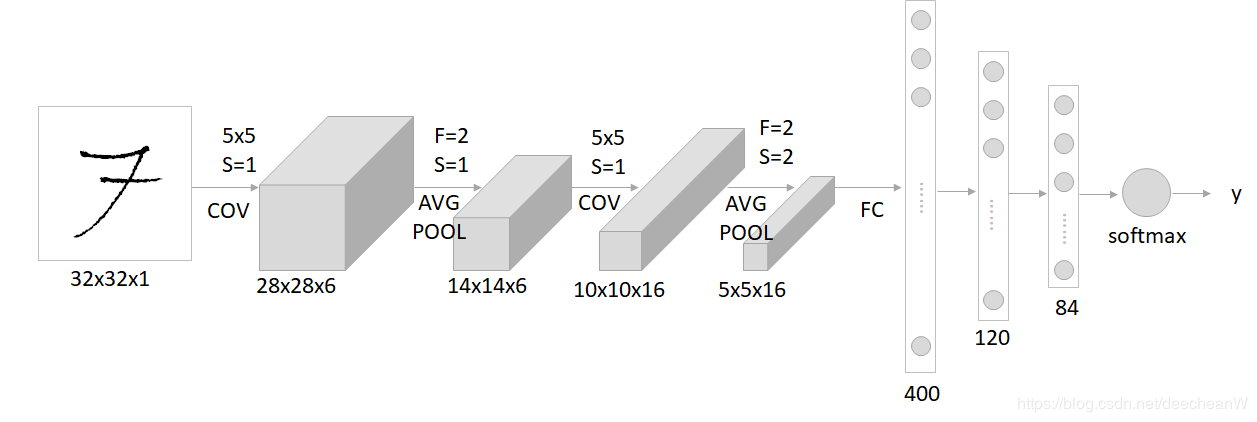


In [3]:
class LeNet5(object):
    def __init__(self, x, n_class=10, drop_rate=0):
        self.input = x
        self.n_class = n_class
        self.drop_rate = drop_rate
        self._build_net()

    def _build_net(self):
        with tf.name_scope('norm'):    
            self.x_norm = tf.nn.l2_normalize(tf.cast(self.input, tf.float32),axis=1)
        
        with tf.name_scope('conv_1'):
            self.conv1 = tfg.conv2d(self.x_norm, 5, 1, 6, 'conv1', 'VALID')
            print('conv_1: ', self.conv1.get_shape())
        
        
        with tf.name_scope('pool_1'):
            self.pool1 = tfg.avg_pool(self.conv1, 2, 2, 'pool1', 'VALID')
            print('pool_1: ', self.pool1.get_shape())
        
        
        with tf.name_scope('conv_2'):
            self.conv2 = tfg.conv2d(self.pool1, 5, 1, 16, 'conv2', 'VALID','SIGMOID')
            print('conv_2: ', self.conv2.get_shape())
        
        with tf.name_scope('pool_2'):
            self.pool2 = tfg.avg_pool(self.conv2, 2, 2, 'pool2', 'VALID')
            print('pool_2: ', self.pool2.get_shape())   
            
        with tf.name_scope('conv_3'):
            self.conv3 = tfg.conv2d(self.pool2, 5, 1, 120, 'conv3', 'VALID','TANH')
            print('conv_3:', self.conv3.get_shape())
    
        with tf.name_scope('flat_1'):
            self.flat1, self.flat_dim = tfg.flatten(self.conv3)
            print('flat_1:', self.flat1.get_shape())
        
        with tf.name_scope('fc_2'):
            self.fc2 = tfg.fc_layer(self.flat1, 120, 84, 'fc2','SIGMOID')
            print('fc_2 ', self.fc2.get_shape())
        
        with tf.name_scope('fc_3'):
            self.fc3 = tfg.fc_layer(self.fc2, 84, 10, 'fc4','SIGMOID')
            print('fc_3: ', self.fc3.get_shape())

        with tf.name_scope('drop_out'):
            self.drop1 = tfg.drop_out(self.fc3, self.drop_rate, 'drop_out')
            print('drop_out: ', self.drop1.get_shape())

        with tf.name_scope('prediction'):
            self.prediction = tf.nn.softmax(self.drop1)
            print('prediction: ', self.prediction.get_shape())

## Section 4. Input layer 
Use the data feeder to provide the training data. Therefore we define a placeholder with the same structure of the input data. 
The CIFAR-10 data is 60000 RGB images with each size is 32x32. The data structure should be[batchsize, 32,32,3]. Input channels are 3.  

In [4]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None,32,32,3], name='x_input')
    drop_rate = tf.placeholder(tf.float32, name='drop_rate')
    y_ = tf.placeholder(tf.int64, [None], name='labels')

In [5]:
with tf.name_scope('prediction'):
    le_net5 = LeNet5(x, drop_rate)
    y = le_net5.prediction

Instructions for updating:
Colocations handled automatically by placer.
conv_1:  (?, 28, 28, 6)
pool_1:  (?, 14, 14, 6)
conv_2:  (?, 10, 10, 16)
pool_2:  (?, 5, 5, 16)
conv_3: (?, 1, 1, 120)
flat_1: (?, 120)
fc_2  (?, 84)
fc_3:  (?, 10)
drop_out:  (?, 10)
prediction:  (?, 10)


## Calculate the cross entropy as the loss

In [6]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                                  labels=y_, 
                                                                                  name="cross_entropy_per_example"))

## Use Adagrad to minimize the loss

In [7]:
with tf.name_scope('train_step'):
    train_step = tf.train.AdagradOptimizer(FLAGS.lr).minimize(cross_entropy)

## Calculate the reduce mean as the accuracy

In [8]:
with tf.name_scope('train_accuracy'):
    prediction =tf.argmax(y, 1)
    accuracy = tf.reduce_mean(tf.cast( tf.equal(prediction,y_), tf.float32))

## Now, let's start the training...

In [9]:
import time

if __name__ == '__main__':
    data = cifar10(data_path);

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver(max_to_keep=1)
        if CONTINUE != 0:
            model_file=tf.train.latest_checkpoint(ckpt_dir)
            saver.restore(sess,model_file)
        for i in range(CONTINUE, FLAGS.epoch):
            train_image, train_label,_ = data.get_train_batch(FLAGS.batch_size,FLAGS.augument)
            loss, _,accuracy_rate = sess.run([cross_entropy, train_step, accuracy], 
                                             feed_dict={drop_rate: FLAGS.drop_rate, x:train_image, y_:train_label})
            
            log.add_log('train_accuracy',i, accuracy_rate)
            log.add_log('train_loss',i, loss)
            if (i+1) % FLAGS.ckpt_frequency == 0:  #保存预测模型
                saver.save(sess,ckpt_dir+'cifar10_'+str(i+1)+'.ckpt',global_step=i+1)
                acc_accuracy = 0
                for j in range(int(10000/FLAGS.test_size)):                    
                    test_image, test_label,test_index = data.get_test_batch(FLAGS.test_size)
                    accuracy_rate, output = sess.run([accuracy,prediction],
                                                     feed_dict={drop_rate: 1, x:test_image, y_:test_label})
                    acc_accuracy += accuracy_rate
                    log.add_log('test_index',i, test_index)
                    log.add_log('output',i, output)
                accuracy_rate = acc_accuracy/10000*FLAGS.test_size
                print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + 
                      ' iter ' + str(i) + ', Test accuracy:' +str(round(accuracy_rate*100,2))+'%')
                log.add_log('test_accuracy',i, accuracy_rate)
                log.SaveToFile()
    tf.reset_default_graph()

train set length: 50000
test set length: 10000
2019-06-16 13:30:45 iter 124, Test accuracy:10.0%
Instructions for updating:
Use standard file APIs to delete files with this prefix.
2019-06-16 13:38:27 iter 249, Test accuracy:10.0%
2019-06-16 13:47:33 iter 374, Test accuracy:10.0%


KeyboardInterrupt: 